# If running on colab, execute this cell
(It will run for a while and then say that the kernel crashed, that means it worked)

In [ ]:
# Execute this cell to make this notebook's dependencies available
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()
# Pin numpy=1.22 because colab comes built with it and will get 
# unhappy if we install anything newer
!mamba install -q -c hexrd -c conda-forge hexrd matplotlib numpy=1.22

## Download the .cif files for each material and the experimental data

In [1]:
# This downloads Cu3P from open crystallography database
! curl -O https://www.crystallography.net/cod/1527899.cif
# This downloads CuP2 from open crystallography database
! curl -O https://www.crystallography.net/cod/1541349.cif
# This downloads Cu2P7 from catalysthub
! curl  -o "Cu2P7-38854.cif" "http://www.catalysthub.net/file.php?ftype=cif&id=38854&code=1484134067"
# This downloads the experimental data from the Prague group's GitHub (needed if running in colab, harmless otherwise)
! curl -O https://raw.githubusercontent.com/me2d09/lk99/main/analysis/Cu3P/230804_Cu3P_geom.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2022  100  2022    0     0   2699      0 --:--:-- --:--:-- --:--:--  2721
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1963  100  1963    0     0   2816      0 --:--:-- --:--:-- --:--:--     0--  2849
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1944    0  1944    0     0   2216      0 --:--:-- --:--:-- --:--:--  2234
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55729  100 55729    0     0   208k      0 --:--:-- --:--:-- --:--:--  215k


# Format the experimental data as [x, y] points
Also save them to a .xy file in case anyone wants the data that way

In [1]:
from matplotlib import pyplot
import numpy as np
data = open('230804_Cu3P_geom.dat').read().split('\n')[1:]


In [2]:
data_formatted = []
with open('data_formatted.xy', 'w') as of:
    for x_val, y_val in zip(np.arange(5, 100, 0.02), data):
        data_formatted.append([float(x_val), float(y_val)])
        of.write(f"{x_val:8.2f} {y_val}\n")
data_formatted = np.array(data_formatted)

In [3]:
!head -n 10 data_formatted.xy

    5.00 4.585117125
    5.02 0
    5.04 4.548750496
    5.06 0
    5.08 13.53887026
    5.10 0
    5.12 0
    5.14 0
    5.16 8.886069268
    5.18 0


## Make HEXRD "Material" objects using .cif files for Cu3P, CuP2, Cu2P7

In [4]:
from hexrd.material import Material
from hexrd.valunits import valWUnit

# A wavelength of 1.540562 A is equivalent to an energy of 8047.98 eV
# Ran this math on https://people.mbi.ucla.edu/sumchan/crystallography/ang-eV_convertor.html

cu3p = Material(material_file='1527899.cif',
               kev=valWUnit("xrayenergy", "energy", 8.048, "keV"))
# Tell it to use a lot of "hkls" (I think this means try lots 
# of reflections or something, the default of 5 doesn't seem 
# to capture the big peaks)
cu3p.enable_hkls_below_index(index=100)
cu3p.update_structure_factor()

cup2 = Material(material_file='1541349.cif',
                kev=valWUnit("xrayenergy", "energy", 8.048, "keV"))
cup2.enable_hkls_below_index(index=100)
cup2.update_structure_factor()

cu2p7 = Material(material_file='Cu2P7-38854.cif',
                 kev=valWUnit("xrayenergy", "energy", 8.048, "keV"))
cu2p7.enable_hkls_below_index(index=100)
cu2p7.update_structure_factor()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/jeffreywagner/conda/envs/hexrd/lib/python3.10/site-packages/hexrd/material.py:533: UserWarning: occupation fraction not present. setting it to 1
  warn('occupation fraction not present. setting it to 1')
/Users/jeffreywagner/conda/envs/hexrd/lib/python3.10/site-packages/hexrd/material.py:556: UserWarning: 'Debye-Waller factors not present. setting to same values for all atoms.'
  warn(msg)


# Plot experimental data against Cu3P prediction

The key takeaway is that the peaks don't match and so this probably isn't Cu3P.

Note that I do completely arbitrary scaling on the X axis here! I have no background in crystallography and I made these numbers up. It doesn't seem to correspond to a degree/radian conversion or anything. I don't understand why this makes the peaks line up and this entire approach may be invalid!

In [5]:
# Arbitrary scale for Y axis
scale=10

ttharray = np.arange(0, 100, 0.02)

cu3p.compute_powder_overlay(ttharray=ttharray, scale=scale)
cup2.compute_powder_overlay(ttharray=ttharray, scale=scale)
cu2p7.compute_powder_overlay(ttharray=ttharray, scale=scale)

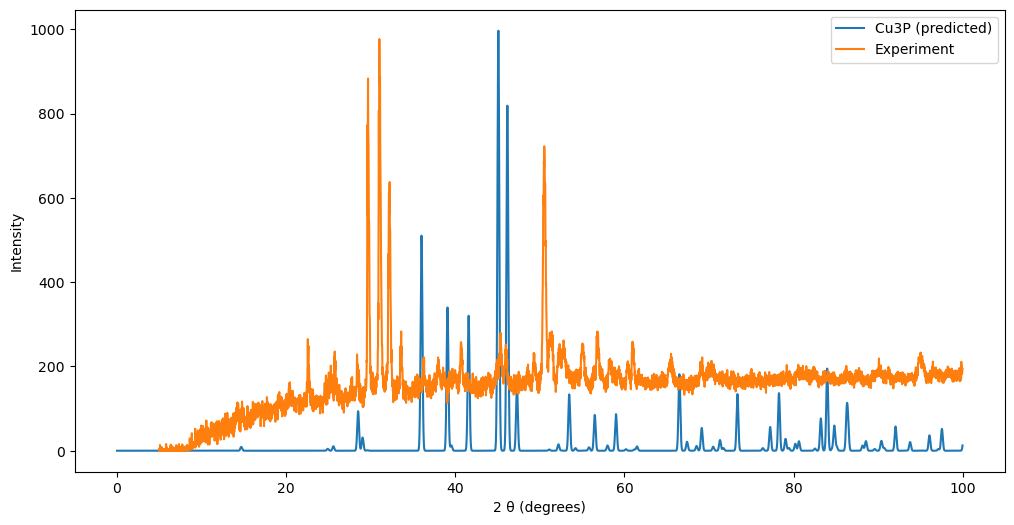

In [6]:
pyplot.plot(ttharray, 
            cu3p.powder_overlay,
            label="Cu3P (predicted)")

pyplot.plot(data_formatted[:,0], 
            data_formatted[:,1],
            label="Experiment"
           )
pyplot.xlabel("2 θ (degrees)")
pyplot.ylabel("Intensity")
fig = pyplot.gcf()
pyplot.legend()
# Make the plot big using freedom units
fig.set_size_inches(12, 6, forward=True)

# Plot experimental data against combinations of CuP2 and Cu2P7 predictions

The key takeaway is that the peak locations roughly match so this may be a mix of CuP2 and Cu2P7

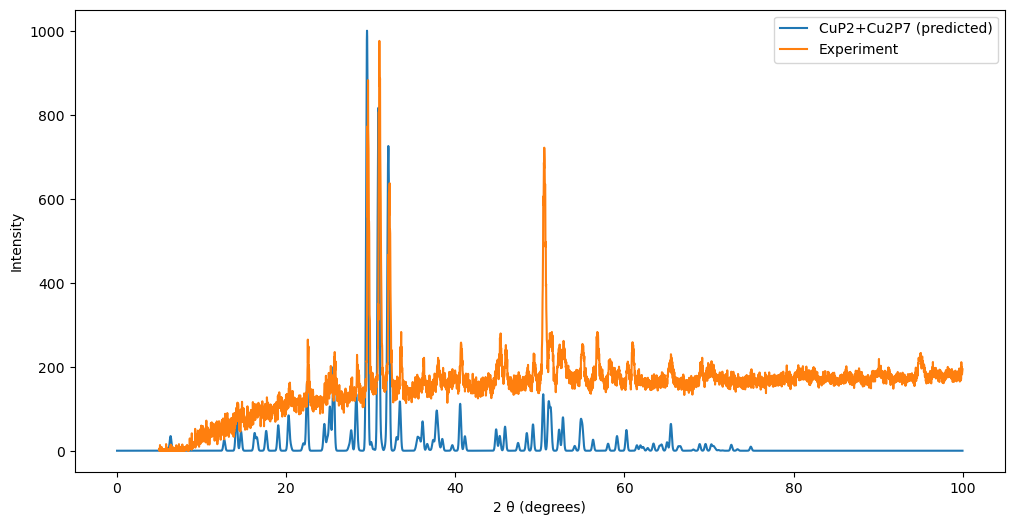

In [7]:
pyplot.plot(ttharray, 
            (cu2p7.powder_overlay + cup2.powder_overlay)/2,
            label="CuP2+Cu2P7 (predicted)")


pyplot.plot(data_formatted[:,0], 
            data_formatted[:,1],
            label="Experiment"
           )
pyplot.xlabel("2 θ (degrees)")
pyplot.ylabel("Intensity")
fig = pyplot.gcf()
pyplot.legend()
# Make the plot big using freedom units
fig.set_size_inches(12, 6, forward=True)


## Comparing the experimental data to JUST CuP2 or Cu2P7 misses some peaks

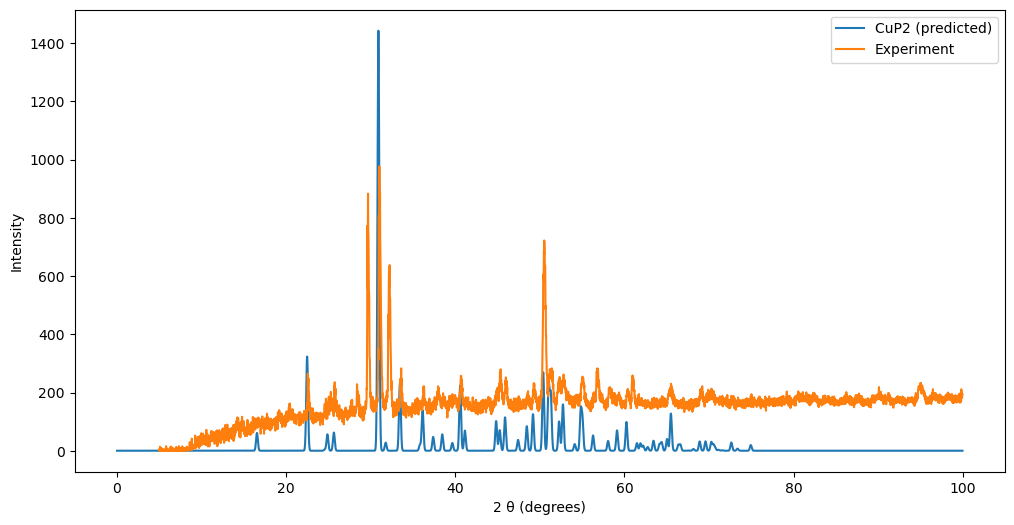

In [8]:
pyplot.plot(ttharray, 
            cup2.powder_overlay,
            label="CuP2 (predicted)")


pyplot.plot(data_formatted[:,0], 
            data_formatted[:,1],
            label="Experiment"
           )
pyplot.xlabel("2 θ (degrees)")
pyplot.ylabel("Intensity")
fig = pyplot.gcf()
pyplot.legend()
# Make the plot big using freedom units
fig.set_size_inches(12, 6, forward=True)


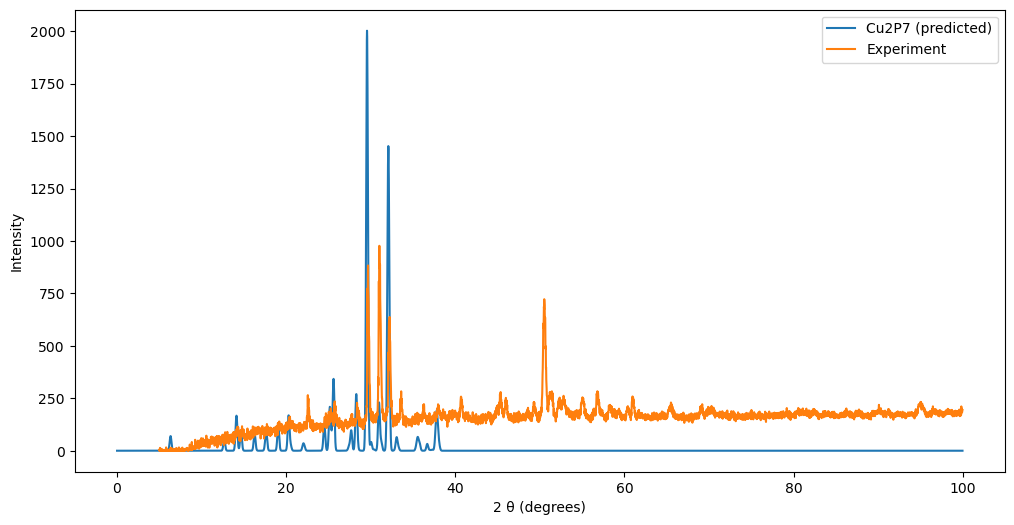

In [9]:
pyplot.plot(ttharray, 
            cu2p7.powder_overlay,
            label="Cu2P7 (predicted)")


pyplot.plot(data_formatted[:,0], 
            data_formatted[:,1],
            label="Experiment"
           )
pyplot.xlabel("2 θ (degrees)")
pyplot.ylabel("Intensity")
fig = pyplot.gcf()
pyplot.legend()
# Make the plot big using freedom units
fig.set_size_inches(12, 6, forward=True)


# Scratch space/garbage snippets below

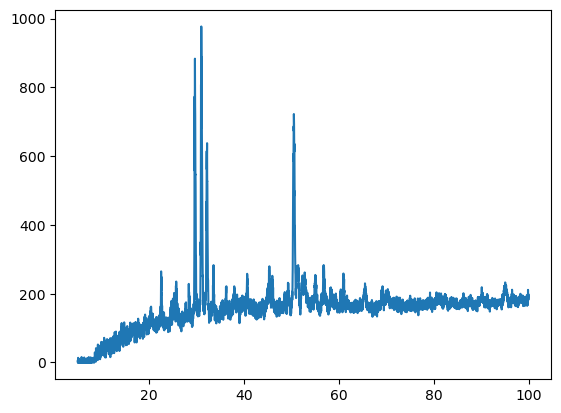

In [10]:
pyplot.plot(data_formatted[:,0], data_formatted[:,1])

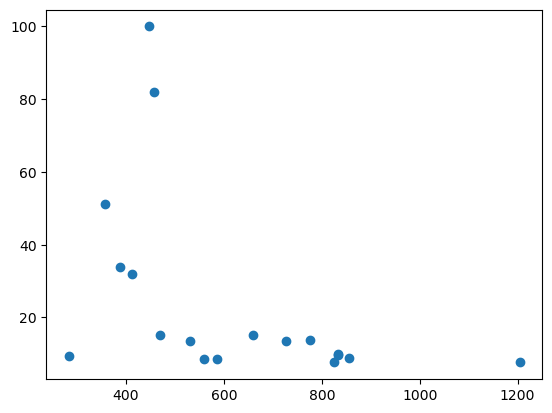

In [11]:
from matplotlib import pyplot
#pyplot.plot(mat.planeData.powder_intensity)
tths_pis = np.array([[1+(np.degrees(tth) * 9.9), pi] 
                     for tth, pi 
                     in zip(cu3p.planeData.getTTh(), cu3p.planeData.powder_intensity) 
                     if (pi > 7 and np.degrees(tth) > 5)])
#print(tths_pis)
pyplot.scatter(tths_pis[:,0], tths_pis[:,1])

In [12]:
print(len(cu3p.planeData.getTTh()), len(cu3p.planeData.powder_intensity))

100 100


In [13]:
from hexrd.instrument.hedm_instrument import HEDMInstrument
hi = HEDMInstrument()
output = hi.simulate_powder_pattern([cu3p])
print(output)
print(output["panel_id_DFLT"].shape)

{'panel_id_DFLT': array([[1187.37631441, 1190.16077799, 1192.95531161, ..., 1192.95531161,
        1190.16077799, 1187.37631441],
       [1190.16077799, 1192.95804953, 1195.76546732, ..., 1195.76546732,
        1192.95804953, 1190.16077799],
       [1192.95531161, 1195.76546732, 1198.58584615, ..., 1198.58584615,
        1195.76546732, 1192.95531161],
       ...,
       [1192.95531161, 1195.76546732, 1198.58584615, ..., 1198.58584615,
        1195.76546732, 1192.95531161],
       [1190.16077799, 1192.95804953, 1195.76546732, ..., 1195.76546732,
        1192.95804953, 1190.16077799],
       [1187.37631441, 1190.16077799, 1192.95531161, ..., 1192.95531161,
        1190.16077799, 1187.37631441]])}
(2048, 2048)


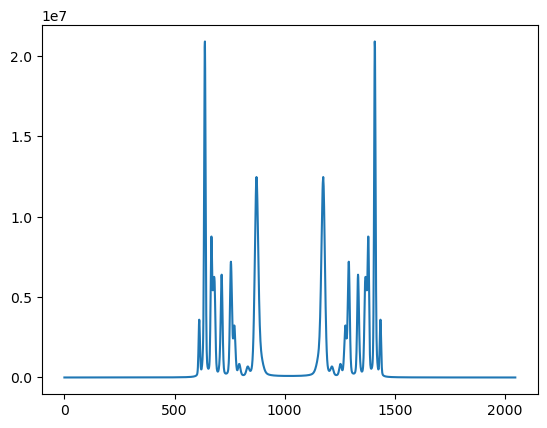

In [14]:
pyplot.plot(output["panel_id_DFLT"][-1])

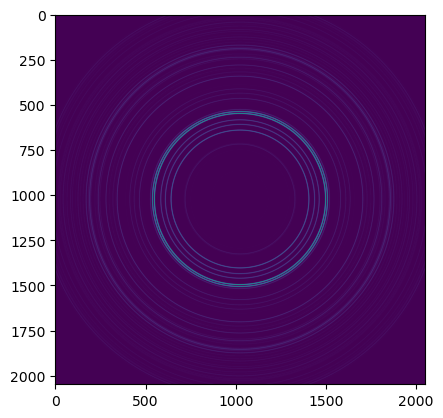

In [15]:
pyplot.imshow(output["panel_id_DFLT"])